### Run Following command to lauch pyspark in notebook mode

```bash

export AWS_ACCESS_KEY=YOUR_AWS_ACCESS_KEY
export AWS_SECRET_KEY=YOUR_AWS_SECRET_KEY

export PYSPARK_DRIVER_PYTHON="jupyter"
export PYSPARK_DRIVER_PYTHON_OPTS="notebook"
export SPARKHOME=YOUR_SPARK_HOME
export PATH_TO_JARS=${SPARKHOME}/jars

${SPARKHOME}/bin/pyspark --master local[2] --jars /opt/symetry/lib/sym-spark-assembly.jar,${PATH_TO_JARS}/aws-java-sdk-1.7.4.jar,${PATH_TO_JARS}/hadoop-aws-2.7.3.jar,${PATH_TO_JARS}/jets3t-0.9.4.jar --driver-java-options -Dsym.lic.loc=/opt/symetry/sym.lic
```

In [1]:
%matplotlib inline

import os
import pyspark
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# This function copies a Java list to a Python list.
# The converted list is totally seperated from its Java version.
def tolist(l):
    if type(l)==py4j.java_collections.JavaList:
        k = []
        for i in range(0,len(l)):
            k.append(tolist(l[i]))
    else:
        k = l
    return k

# Your code Starts from Here

In [3]:
# READ Amazon S3 Credentials from env variables
awsAccessKeyId = os.environ['AWS_ACCESS_KEY']
awsSecretAccessKey = os.environ['AWS_SECRET_KEY']
# print("awsAccessKeyId=" + awsAccessKeyId)
# print("awsSecretAccessKey=" + awsSecretAccessKey)

In [4]:
# Create an RDD from a CSV data file
from pyspark.mllib.common import _py2java, _java2py
from   py4j.java_collections import ListConverter

sc._jsc.hadoopConfiguration().set("fs.s3n.awsAccessKeyId",awsAccessKeyId)
sc._jsc.hadoopConfiguration().set("fs.s3n.awsSecretAccessKey",awsSecretAccessKey)

myrdd  = sc.textFile("s3n://sml-oregon/datasets/susy/SUSYmini.csv")
# Convert pyspark RDD to JavaRDD
myJavaRdd = _py2java(sc, myrdd)

In [5]:
# The first line of CSV file are the name of the attributes
attributeNames = myrdd.first().split(",")
# The attributeTypes has to be given
attributeTypes = ["B"]+["C"]*(len(attributeNames)-1)

In [6]:
# The IP address of the host if empty, project is not persisted. (Not Persisted Here)
#sym.SymShellConfig.set("RedisHost","localhost")
#sym.SymShellConfig.set("RedisPort",6379)

In [7]:
# 1) Create the Project here
projectName     = "amazonS3ExampleInNotebook"
userName        = "c1"
projectType     =  0         # 0: Using CPU, 11:using GPU
gateway         = sc._gateway
sym             = gateway.jvm.com.sml.shell
p               = sym.PySparkShellSymetryProject(userName,projectName, projectType)

In [8]:
# 2) Learn the RDD
# sc : is the SparkContext which is automatically generated (sc._jsc: is its Java version)
p.learn(sc._jsc, myJavaRdd, attributeNames, attributeTypes, None)

In [9]:
# 3)  some data exploration (univariate, and bivariate Statistics)
print(p.univariate(4)) # exploration , see whether the project has been built correctly
print(p.univariate("lepton-2-pT")) # You may pass the name of the attribute as well
stats = p.univariate("lepton-2-pT")

{'variance': 0.3513659985432808, 'mean': 0.9849899268824199, 'count': 1999.0, 'skewness': 2.648875873916381, 'stddev': 0.5927613335426669}
{'variance': 0.3513659985432808, 'mean': 0.9849899268824199, 'count': 1999.0, 'skewness': 2.648875873916381, 'stddev': 0.5927613335426669}


In [10]:
# Measuring some univariate statistics
x = range(1,len(attributeNames))
attrVariance=[p.univariate(i-1)["variance"] for i in x]
attrMean=[p.univariate(i-1)["mean"] for i in x]

Plotting Distributions


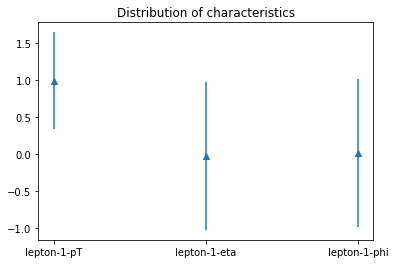

In [11]:
print("Plotting Distributions")
l1ptv = p.univariate("lepton-1-pT")['stddev']
l1ptm = p.univariate("lepton-1-pT")['mean']
l1ev = p.univariate("lepton-1-eta")['stddev']
l1em = p.univariate("lepton-1-eta")['mean']
l1pv = p.univariate("lepton-1-phi")['stddev']
l1pm = p.univariate("lepton-1-phi")['mean']
x = ['lepton-1-pT','lepton-1-eta','lepton-1-phi']
e = np.array([l1ptv,l1ev,l1pv])
y = np.array([l1ptm,l1em,l1pm])
plt.errorbar(x, y, e, linestyle='None', marker='^')
plt.title('Distribution of characteristics')
plt.show()

In [12]:
print(p.bivariate("lepton-2-pT","lepton-2-phi")["linCorr"])

-0.020117106364078388


In [13]:
# calculate the pairwise correlation coefficients
linCorr=[]
for attr1 in attributeNames:
    temp = []
    for attr2 in attributeNames:  
        b1=p.bivariate(attr1,attr2) #calculates two bivariate statistics
        temp.append(b1["linCorr"])
    linCorr.append(temp)

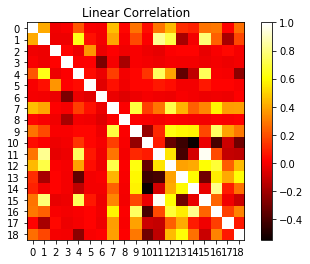

In [14]:
plt.xticks(range(0,len(attributeNames)))
plt.yticks(range(0,len(attributeNames)))
plt.imshow(linCorr,cmap="hot",interpolation='none')
plt.title("Linear Correlation")
_ = plt.colorbar()

In [15]:
# 4) Perform PCA
e1 = p.pca(range(1,19)) # returns a Tuple[eigenvalues,eigenvectors]
print(e1["EigenValues"][0])                                     # the first eigen-values
print(e1["EigenVectors"][0])                                      # the first eigen-vectors

2.3567339824633438
[-0.1715650863859292, 0.37180823863357193, 0.10968450448516984, -0.03554998017910107, -0.049307628024638235, -0.23443750366301394, -0.04144273125975512, -0.035095656772826285, -0.00822403116548479, 0.40360445267389683, -0.10604810956401972, -0.36305390489440054, -0.4793549225480865, 0.15231892354310853, -0.19347572984756442, -0.038900035171927326, -0.3965040983530511, -0.059379099549966105]


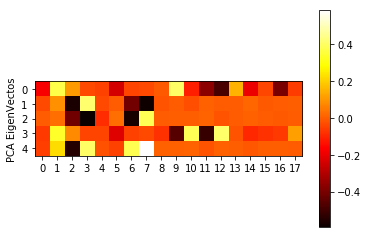

In [16]:
v = e1["EigenVectors"][0:5]
v = tolist(v)
# in order to plot e1 ,we need to convert it to a List, we used predefined tolist function

plt.xticks(range(0,len(attributeNames)))
plt.yticks(range(0,len(attributeNames)))
plt.imshow(v,cmap="hot",interpolation='none')
plt.ylabel("PCA EigenVectos")
plt.colorbar()

In [17]:
e2 = p.pca([
    "lepton-1-pT",
    "lepton-1-eta", "lepton-1-phi",
    "lepton-2-pT", "lepton-2-eta"])

In [18]:
# 5) Build model
tar   = [0]                              # The forth Attribute is used as Target
input = range(1,19)                      # The first four attribute used as as Input
 
p.buildModel(input, tar, "lsvm", "mySvmModel")       # The Model is know built

0

In [19]:
# One row of data (Attributes are comma separated)
# Here in this model, the first Attribute is the Target,
# we put an arbitrary value as it will be ignored in the prediction

# The response for this example should be 1
test1 = ["-1","1.667973", "0.0641906","-1.2251714",
"0.506102", "-0.3389389", "1.6725428",
"3.475464", "-1.2191363", "0.0129545",
"3.775173", "1.0459771",  "0.5680512",
"0.481928", "0.0000000", "0.4484102",
"0.205355", "1.3218934", "0.3775840"]

df1 = sym.PyDataFrame() # The dataframe has to be type PyDataFrame
df1.setAttributeNames(attributeNames)
df1.setAttributeTypes(attributeTypes)
df1.addTuple(test1)
results1 = p.predict(df1,"mySvmModel")
print(results1)

{'res': ['1'], 'svmres0': ['0.39753483949230883']}


In [20]:
# The response for this example should be 0
test2 = ["-1","1.001869","-0.471788","0.555614",
"1.233368","1.255548","-1.052491",
"0.437615","-1.333052","0.326858",
"-0.111678","1.435708","0.755201",
"0.466779","0.454541","1.446331",
"0.592259","1.325197","0.083014"]

df1.clear()
df1.addTuple(test2)
results2 = p.predict(df1,"mySvmModel")
print(results2)

{'res': ['0'], 'svmres0': ['-0.12452965916655959']}


In [21]:
# STEP 6) You can delete the Model to release the used memory
p.deleteModel("mySvmModel")

# STEP 7) Tou can delete the Project to release the used memory
p.deleteProject()

In [22]:
print("amazonS3Example.ipynb end")

amazonS3Example.ipynb end
